# Look into the sea level budget data from Frederikse et al. 2020

In [15]:
import importlib
import sys
sys.path.append('../code')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import SeaLevelContrib as slc

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [16]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/notebooks/../code/SeaLevelContrib.py'>

In [17]:
def rotate_longitude(ds):
    '''Rotate the longitude of an xarray dataset from [0,360] to [-180,180]'''
    
    if 'lon' in ds.dims:
        lon = 'lon'
    elif 'longitude' in ds.dims:
        lon = 'longitude'
    else:
        print('Longitude not found in dimensions')
        
    ds[lon] = np.where(ds[lon]>180, ds[lon]-360, ds[lon])
    ds = ds.reindex({ lon : np.sort(ds[lon])})
    
    return ds

In [4]:
data_dir = '../data/Frederikse2020/'

## Terrestrial water storage

In [5]:
tws_ds = xr.open_dataset(f'{data_dir}tws.nc')
tws_ds = rotate_longitude(tws_ds)

In [6]:
tws_ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 119)
Coordinates:
  * lon            (lon) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) int16 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018
Data variables:
    tws_rsl_mean   (time, lat, lon) float32 ...
    tws_rsl_sterr  (time, lat, lon) float32 ...
    tws_rad_mean   (time, lat, lon) float32 ...
    tws_rad_sterr  (time, lat, lon) float32 ...
Attributes:
    copyright:  This work is licensed under the Creative Commons Attribution-...

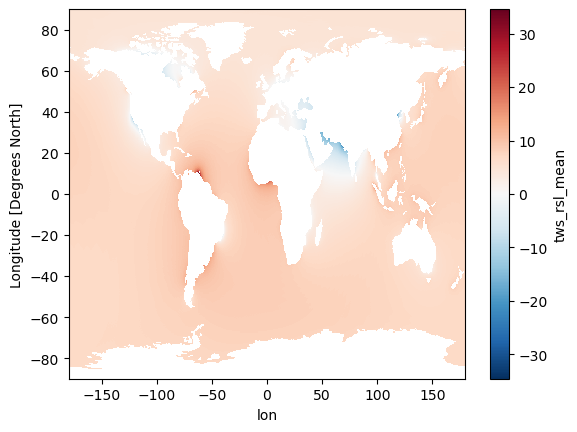

In [7]:
(tws_ds.tws_rsl_mean.sel(time = 2018) - tws_ds.tws_rsl_mean.sel(time = 1979)).plot()

In [8]:
tg_id = [20, 22, 23, 24, 25, 32]

In [12]:
coord = slc.tg_lat_lon(tg_id[0])

tws_df = slc.contrib_frederikse2020(coord, 'tws')

<AxesSubplot: xlabel='time'>

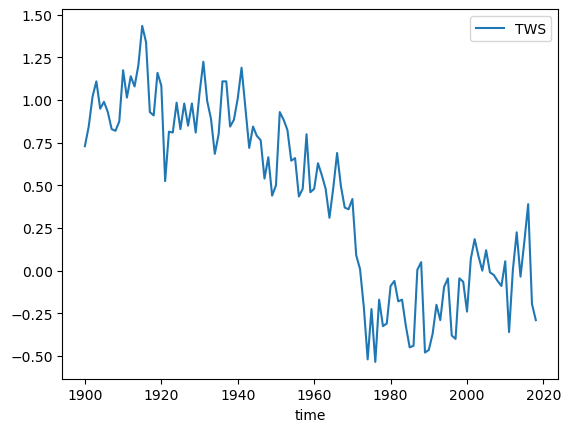

In [14]:
tws_df.plot() # .sel(time=2018).plot()

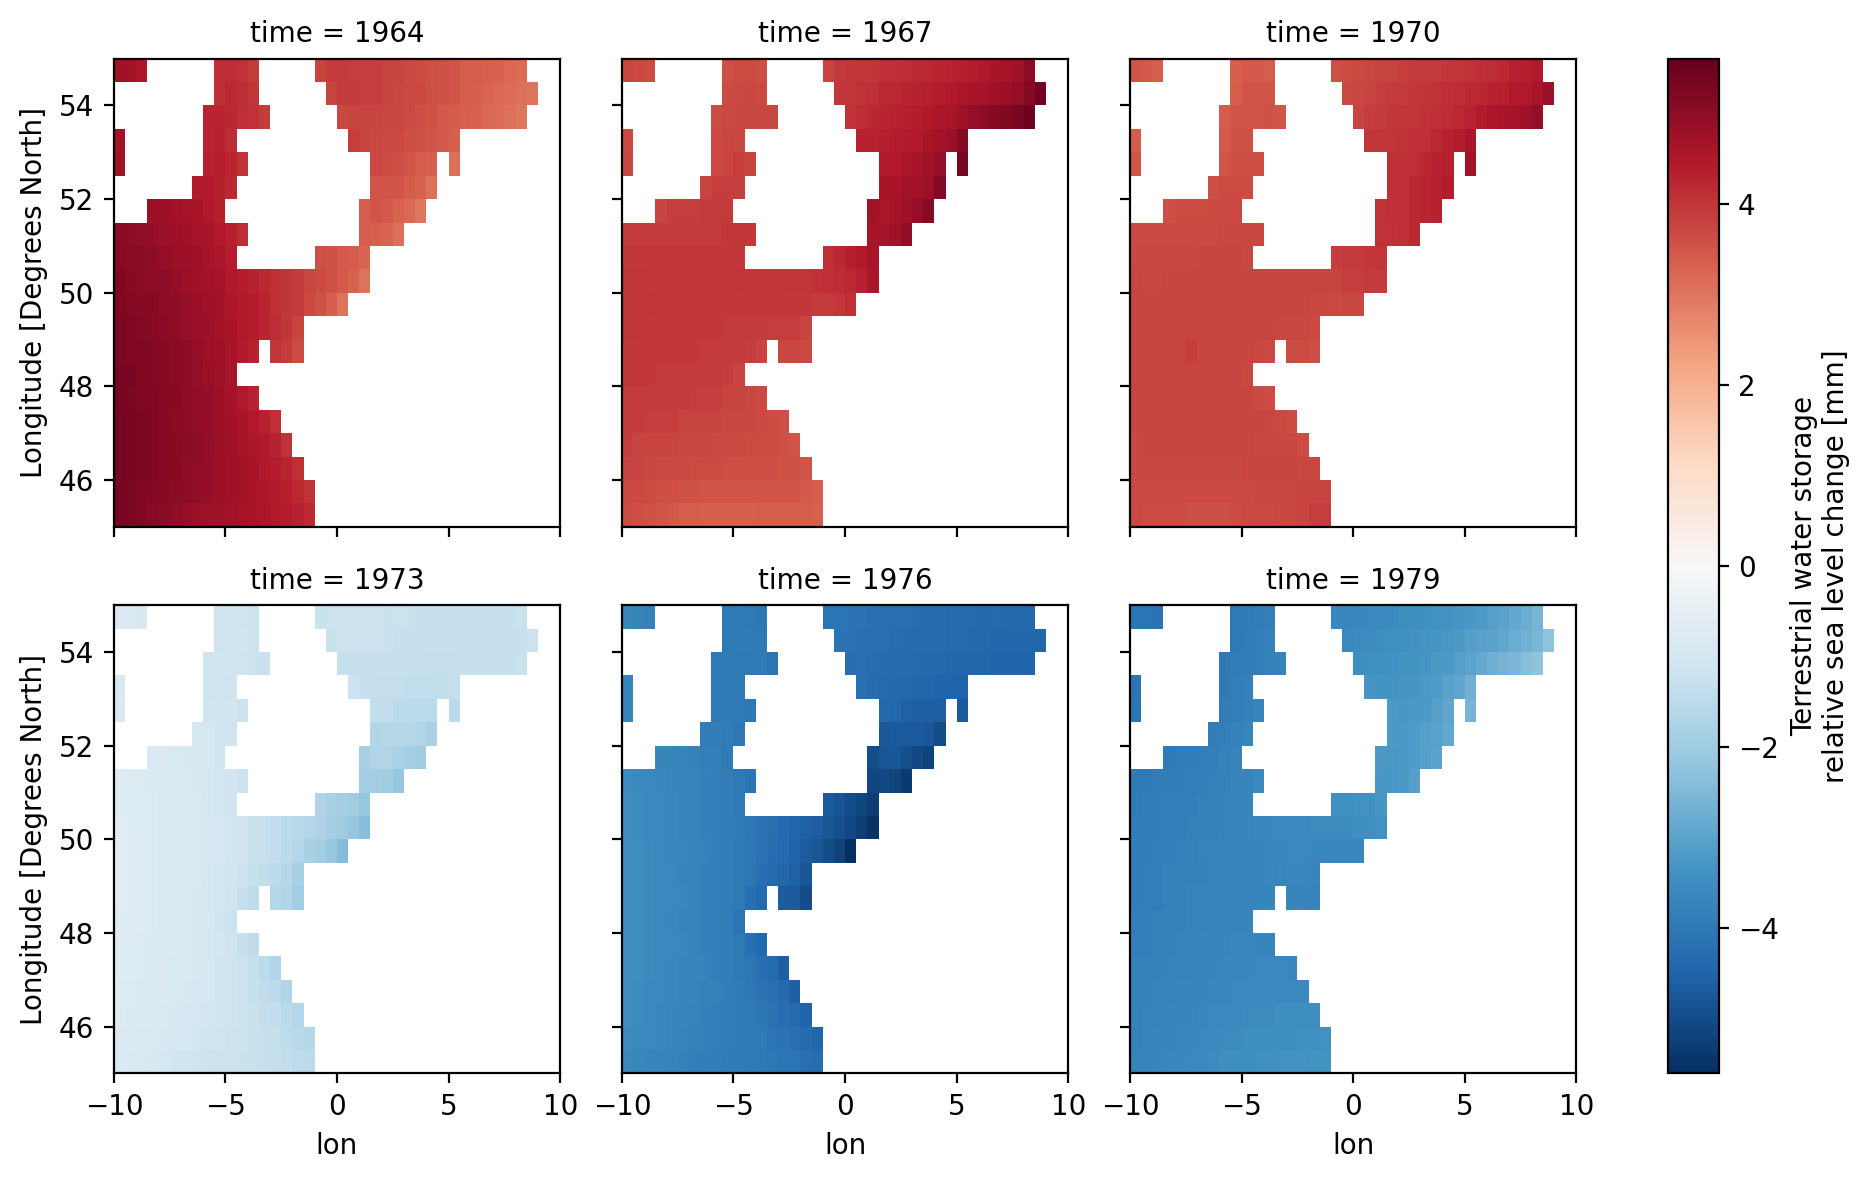

In [18]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3) , lon=slice(-10,10), lat=slice(45,55))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)

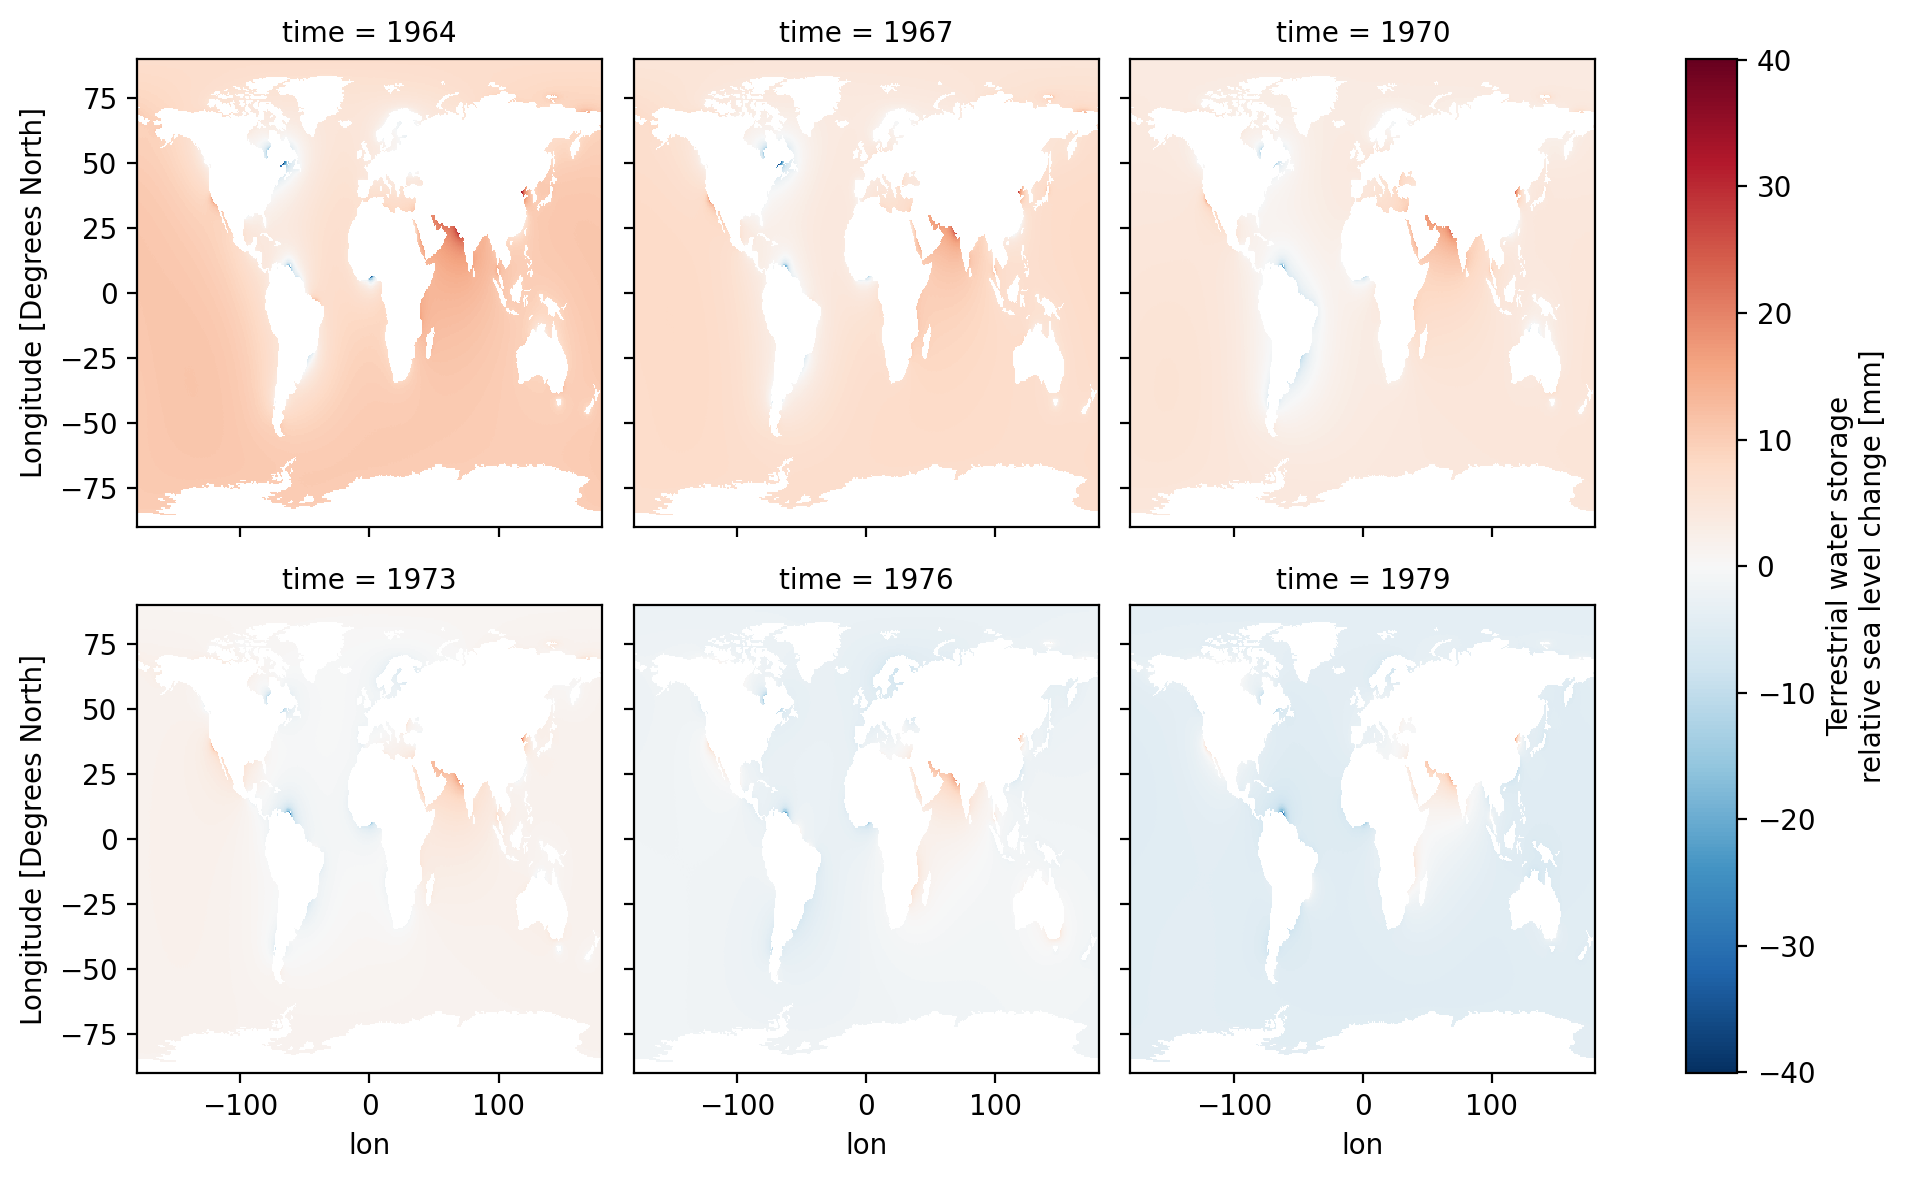

In [19]:
tws_sel = tws_ds.tws_rsl_mean.sel(time=slice(1964,1980,3))
tws_sel.plot(x='lon', y='lat', col='time', col_wrap=3)

## Steric

In [20]:
st_ds = xr.open_dataset(f'{data_dir}steric.nc')
st_ds = rotate_longitude(st_ds)

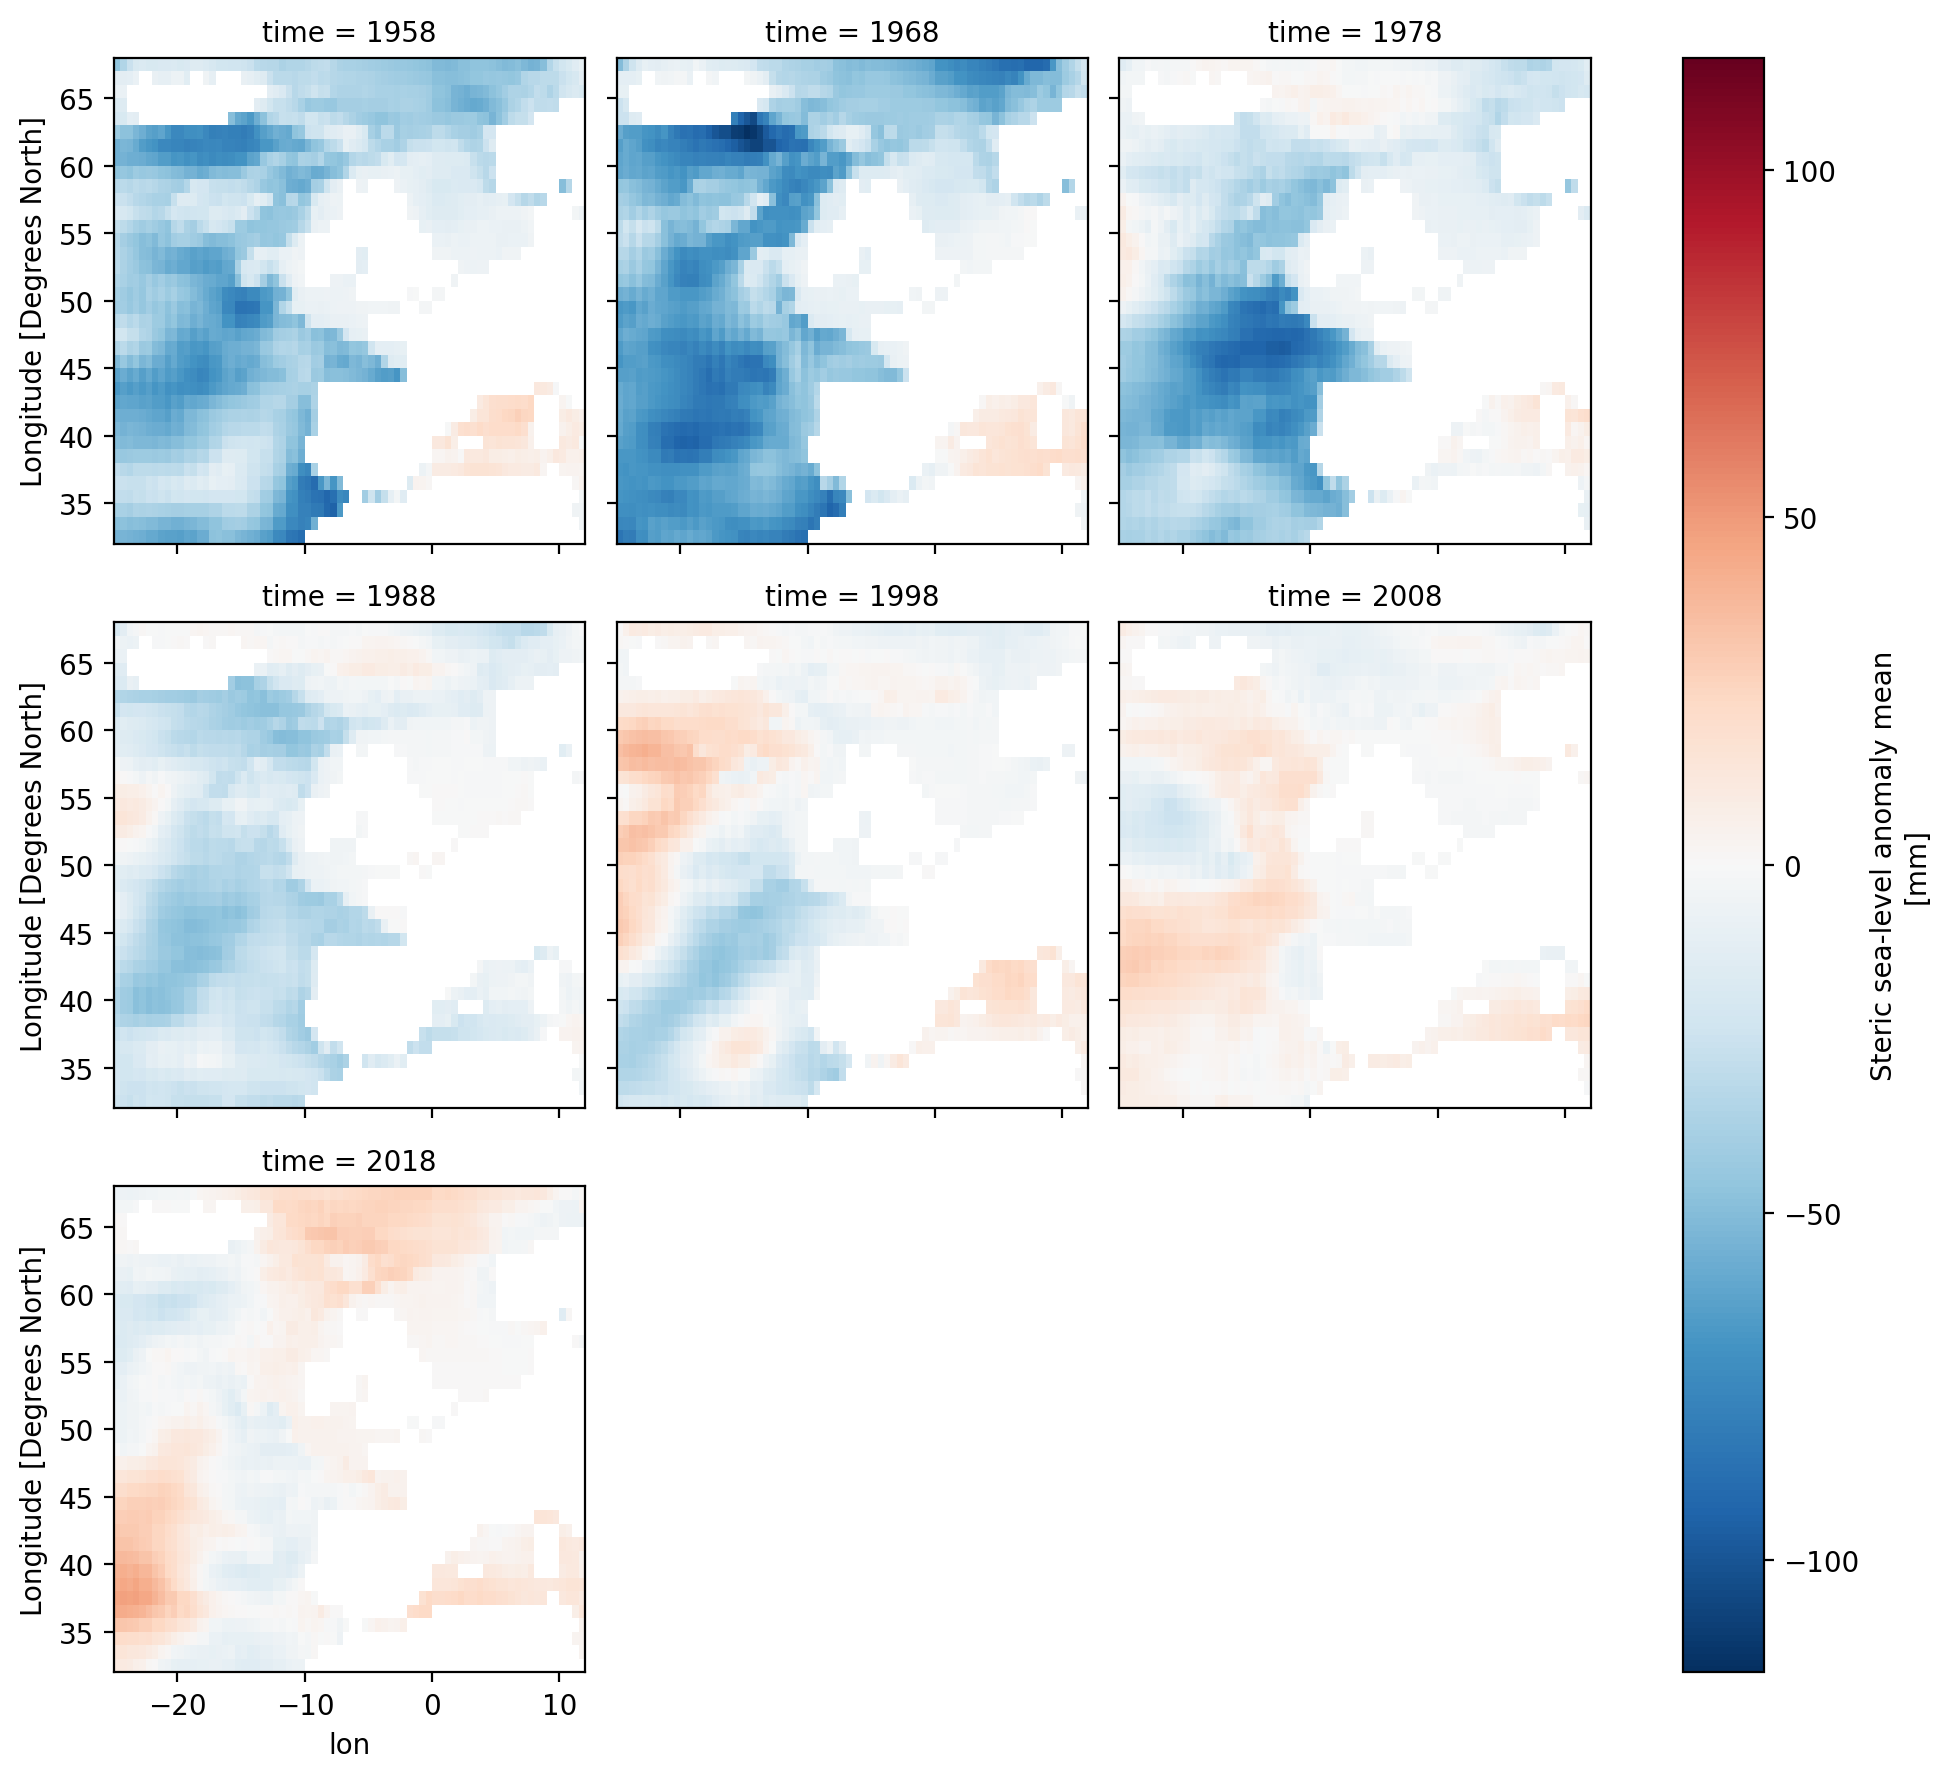

In [21]:
st_ds.steric_mean.sel(time=slice(1958,2018,10), lon=slice(-25,12), lat=slice(32,68)).plot(x='lon', y='lat', col='time', col_wrap=3)

In [22]:
st_ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, time: 62)
Coordinates:
  * lon           (lon) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) int16 1957 1958 1959 1960 1961 ... 2015 2016 2017 2018
Data variables:
    steric_mean   (time, lat, lon) float32 ...
    steric_sterr  (time, lat, lon) float32 ...
Attributes:
    copyright:  This work is licensed under the Creative Commons Attribution-...

## Check that the fields can be extrapollated up to 2020

- Add an extrap option to the function
- based on a linear extrap of the preious 5 or 10 years

In [23]:
tg_id = [20, 22, 23, 24, 25, 32]
TWS = slc.contrib_frederikse2020(tg_id, 'tws', extrap=True)
ANT = slc.contrib_frederikse2020(tg_id, 'AIS', extrap=True)
GRE = slc.contrib_frederikse2020(tg_id, 'GrIS', extrap=True)
GLA = slc.contrib_frederikse2020(tg_id, 'glac', extrap=True)

glo_steric_df = slc.contrib_frederikse2020_glob('Steric', extrap=True)

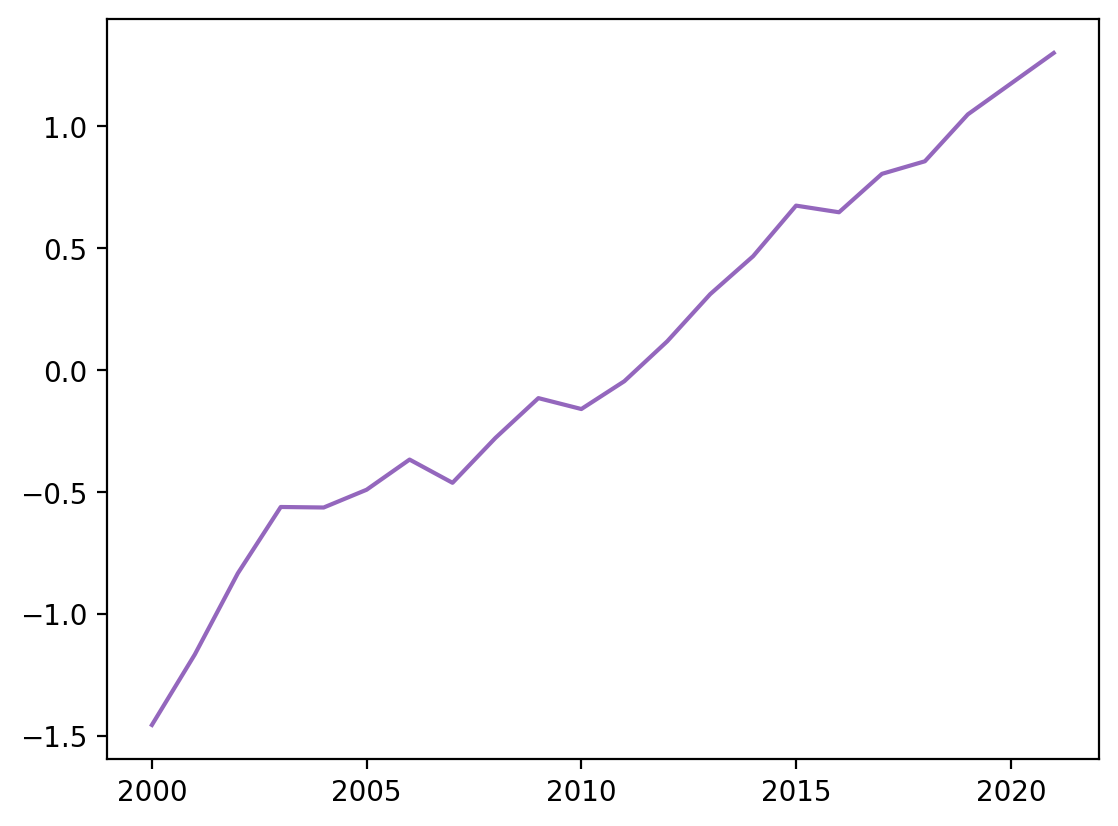

In [24]:
plt.plot(TWS.loc[2000:])
plt.plot(ANT.loc[2000:])
plt.plot(GRE.loc[2000:])
plt.plot(GLA.loc[2000:])
plt.plot(glo_steric_df.loc[2000:])

Looks good enough

## Read the region_info file

In [25]:
region_info_df = pd.read_excel(data_dir  + 'region_info.xlsx', sheet_name='Subpolar North Atlantic')

In [26]:
ZSM = [20, 22, 23, 24, 25, 32] # Tide gauge IDs of Zeespiegelmonitor
for tgi in ZSM:
    cond = (region_info_df['PSMSL IDs'] == str(tgi))
    print(region_info_df[cond])
                
               

    Unnamed: 0 Station names PSMSL IDs   Latitude  Longitude  First year  \
10          11    VLISSINGEN        20  51.442222   3.596111        1900   

    Last year  Number of annual observations  \
10       2018                            118   

                            VLM sources  Residual VLM [lower]  \
10  EEKL; OOS1; SASG; VLIS; ZEEB; ALTTG              -1.21633   

    Residual VLM [mean]  Residual VLM [upper]  
10            -0.433424              0.515838  
Empty DataFrame
Columns: [Unnamed: 0, Station names, PSMSL IDs, Latitude, Longitude, First year, Last year, Number of annual observations, VLM sources, Residual VLM [lower], Residual VLM [mean], Residual VLM [upper]]
Index: []
    Unnamed: 0 Station names PSMSL IDs   Latitude  Longitude  First year  \
12          13    DEN HELDER        23  52.964444      4.745        1900   

    Last year  Number of annual observations VLM sources  \
12       2018                            119       ALTTG   

    Residual VLM [lowe

## Check the use of radial velocity to obtain the absolute sea level budget

In [30]:
aa_ds = xr.open_dataset(f'{data_dir}AIS.nc')
aa_ds = rotate_longitude(aa_ds)


In [31]:
aa_ds

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 119)
Coordinates:
  * lon            (lon) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) int16 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018
Data variables:
    AIS_rsl_mean   (time, lat, lon) float32 ...
    AIS_rsl_sterr  (time, lat, lon) float32 ...
    AIS_rad_mean   (time, lat, lon) float32 ...
    AIS_rad_sterr  (time, lat, lon) float32 ...
Attributes:
    copyright:  This work is licensed under the Creative Commons Attribution-...

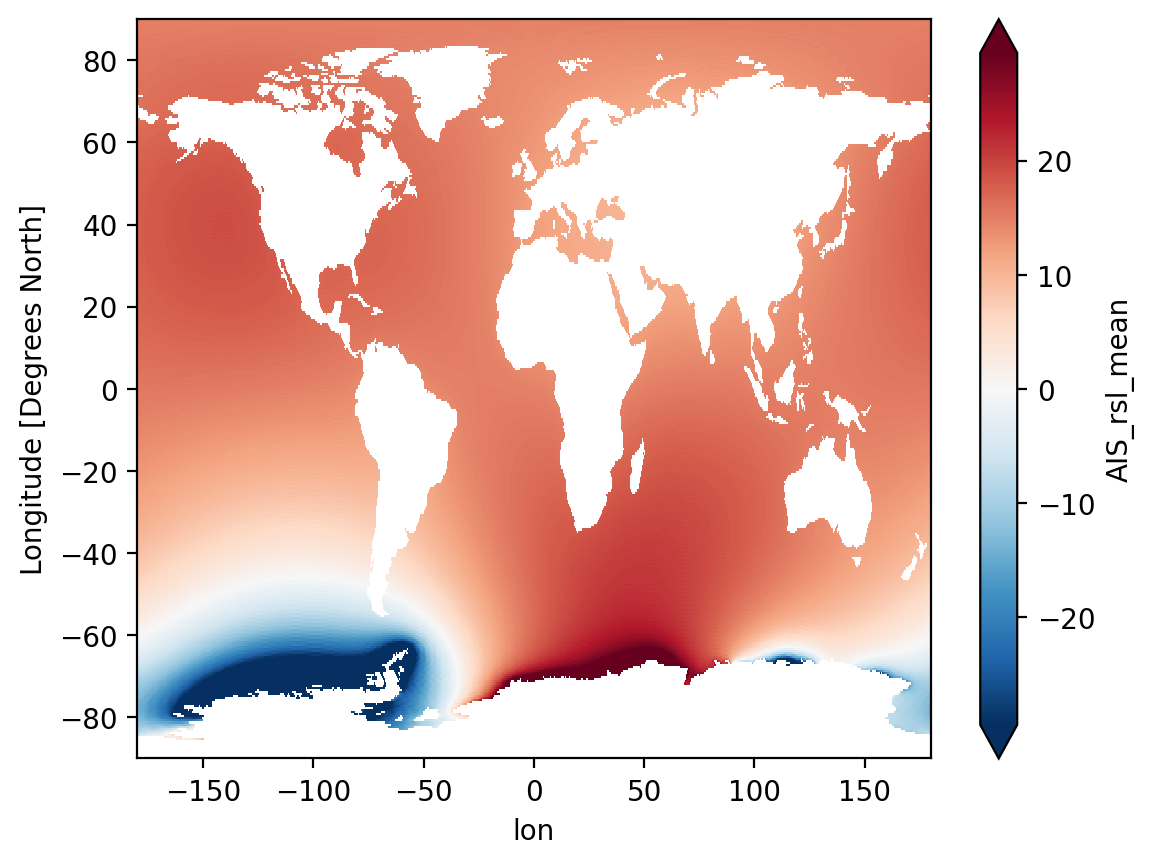

In [35]:
aa_sel = aa_ds.AIS_rsl_mean.sel(time=2018) - aa_ds.AIS_rsl_mean.sel(time=1900)
aa_sel.plot(robust=True)

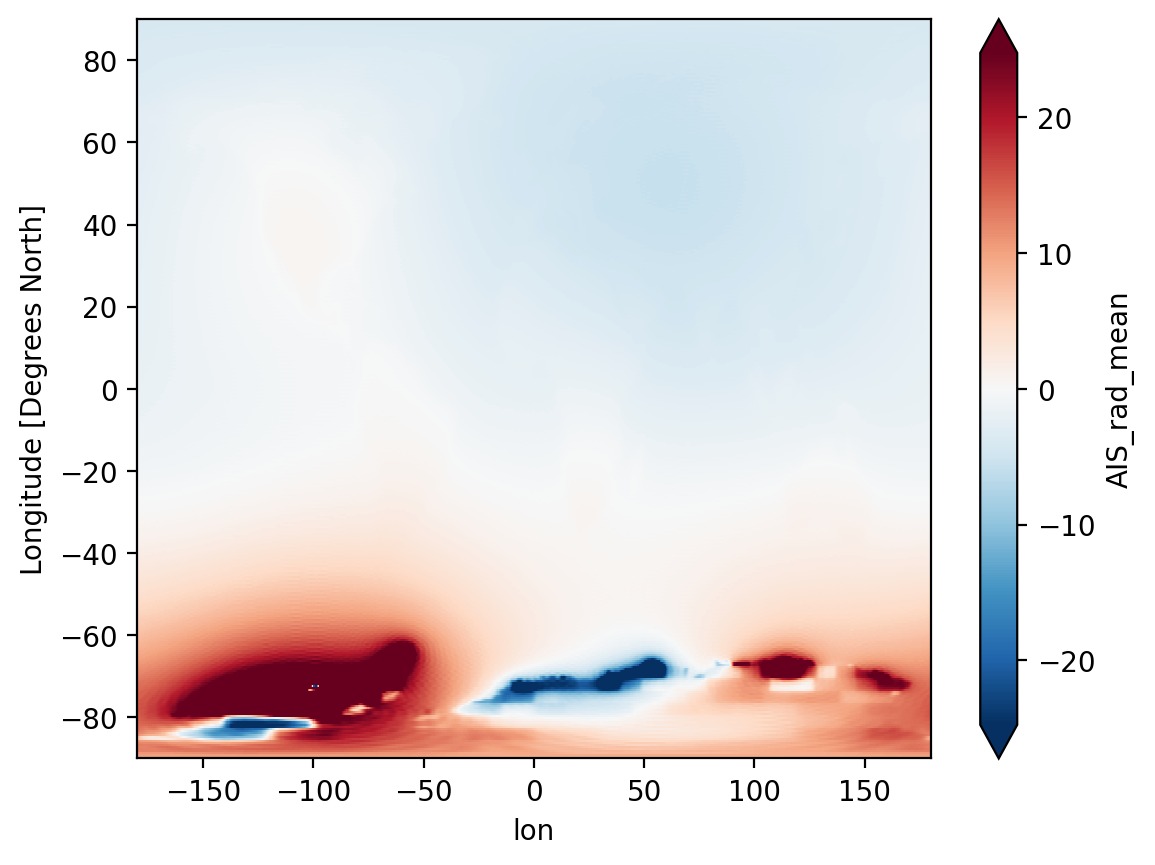

In [36]:
aa_rad_sel = aa_ds.AIS_rad_mean.sel(time=2018) - aa_ds.AIS_rad_mean.sel(time=1900)
aa_rad_sel.plot(robust=True)

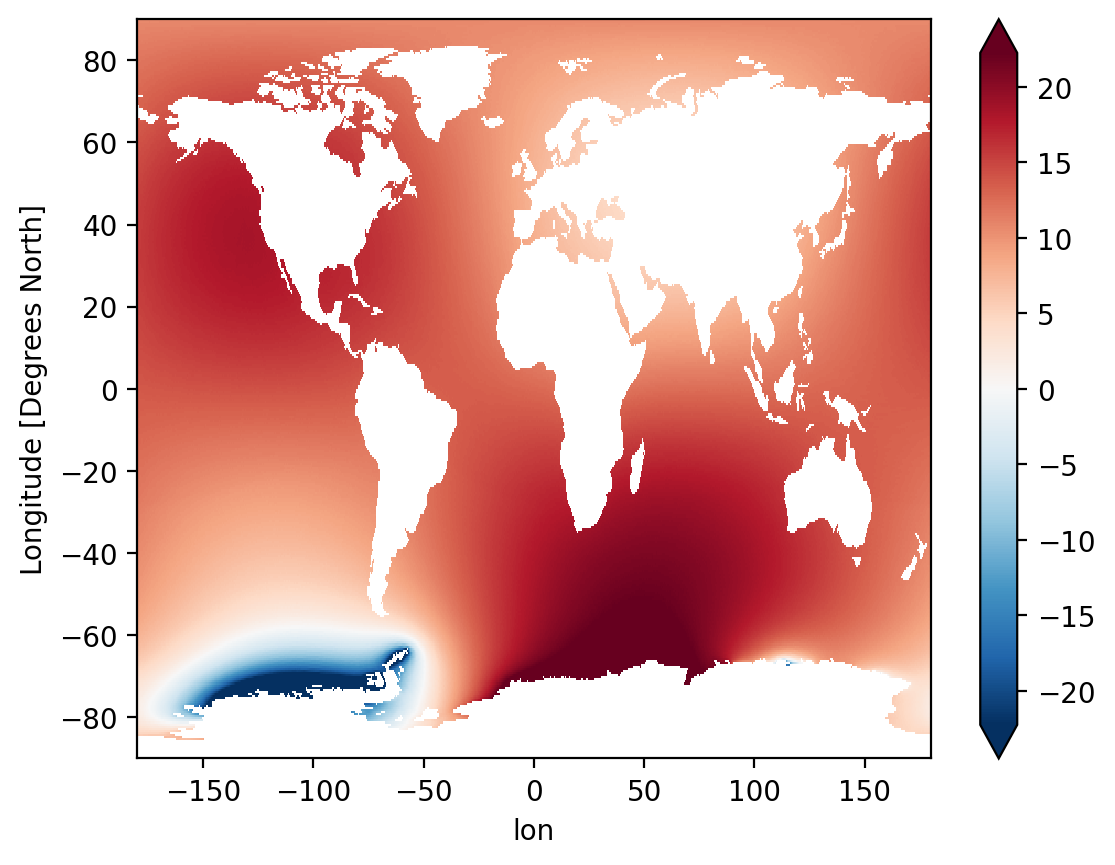

In [37]:
aa_abs = aa_sel+aa_rad_sel
aa_abs.plot(robust=True)

## Compute the fingerprints evolution for absolute and relative sea level